# PyTorch TensorBoard Support

## Introduction

Training variant of LeNet-5 against Fashion-MNIST dataset.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


## Showing Images in TensorBoard

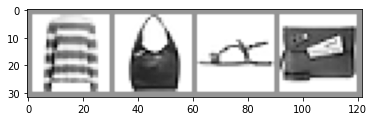

In [3]:
# Gather datasets and prepare for consumption
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Store separate training and validation splits in ./data
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transform
)
training_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2
)

# Class labels
classes = (
    "T-shirt/top",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Helper func for inline image display
def mpl_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)

    img = img / 2 + 0.5  # un-normalise

    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract bath of 4 imgs
dataiter = iter(training_loader)
imgs, labels = dataiter.next()

# Create grid from images and show them
img_grid = torchvision.utils.make_grid(imgs)
mpl_imshow(img_grid, one_channel=True)


In [ ]:
# Use add_image() on SummaryWriter to log image for consumption by TensorBoard
# Call flush() to make sure it's written to disc immediately

writer = SummaryWriter("runs/fashion_mnist_experiment_1")

# Write img data to TensorBoard log dir
writer.add_image("Four Fashion-MNIST Images", img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/
# Or (try to) start VS Code TensorBoard session
